_version log: Adding Ettore's 2d FT code and creating nice plot._

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import patches
from PIL import Image
import pandas as pd
import os, re, sys
from scipy import interpolate as sciinter, signal as scisig, optimize as sciopt, ndimage as sciimage #scipy has a lot of submodules
from astropy.io import fits
plt.rcParams.update({'font.size':14})
np.set_printoptions(threshold=sys.maxsize)

c = 299_792_458 #m/s
source = "big" # "blue" "green" "red" "FBH800" "FBH1600" "ir" "big"
run = "13"
camera = "xeva" #"manta" "xeva" "purple"
file_type = ".csv" # the manta uses .tif, the xeva uses .csv, the purple camera can export .tif or .fts
dead_pixels = 0.1 # % of most anomalous pixels to replace with its nearest neighbour
anti_chirping = False #True for applying Elin's anti-chirping code.
zero_padding = 4 #factor to extrapolate the interferogram by. 1 means no extrapolation. 2 means that the interferogram will double in length. This should interpolate the spectrum rather than improving resolution.
apodization_function = "blackmann-harris" # None "box" "crop" "triangular" "happ-genzel" "blackmann-harris". None and "box" are identical unless you add zero-padding.
angle_calculation_method = "delay" # "manual" for a known angle, "wavelength" for calibration with a known wavelength or "delay" for calulation using a temporal change on the delay line.
angle_between_beams = 15/60 #degrees. Used if angle_calculation_method == "manual"
delay_line_delta = 5 #um. Distance traveled by delay line between each reading. Used if angle_calculation_method == "delay"
calibration_wavelength = 1.6 #um. Used if angle_calculation_method == "wavelength"
ROI = np.array([[0,512],[0,640]]) #region of interest in pixels. rows, columns. [[0,240],[0,320]] [[0,512],[0,640]]

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um
elif camera == "purple":
    pixel_pitch = 48.5 #um
elif camera == "pyro":
    pixel_pitch = 80 #um
else:
    raise ValueError(camera + " is not a valid camera.")

In [99]:
#################FUNCTIONS##################

def none2zero(x): #x should be an interger or None
    return int(x or bool(x)) #a simple if statement would work best but I think this is cooler.

def line(x,A,B):
    return A + B*x
     
def cubic(x,A,B,C,D):
     return A + B*x + C*x**2 + D*x**3

def cubic_residuals(x, y, A, B, C, D):
    return cubic(x, A, B, C, D) - y

def recip(x):
    return c*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa. 

def format_ticks(x, pos):
    return f"{x:.0f}"  # Format the tick label with two decimal places

def find_best_peak(interferograms, height=None, threshold=None, distance=None, width=None, wlen=None, rel_height=0.5, plateau_size=None):
    if interferograms.ndim == 1:
        peaks, peaks_properties = scisig.find_peaks(interferograms, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = peaks[best_peak_index]
        peak_properties = {key: value[best_peak_index] for key, value in peaks_properties.items()}
    
    elif interferograms.ndim == 2:
        interferograms = interferograms.transpose() #Use the right set of axes.
        peaks, peaks_properties = scisig.find_peaks(interferograms[0], height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = [peaks[best_peak_index]]
        peak_properties = {key: [value[best_peak_index]] for key, value in peaks_properties.items()}

        for interferogram in interferograms[1:]:
            peaks, peaks_properties = scisig.find_peaks(interferogram, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
            best_peak_index = np.argmax(peaks_properties["prominences"])
            peak = np.concatenate([peak, [peaks[best_peak_index]]])
            peak_properties = {key: peak_properties[key] +[value[best_peak_index]] for key, value in peaks_properties.items()}

    return peak, peak_properties


def angular_slice(phi, FT2d, width= 1):

    diameter = int(np.sum(np.array(ROI[:,1])**2)**0.5) #The length of the diagonal. This is the largest diameter that we will need.
    x = np.arange(-diameter//2, diameter//2) *np.cos(phi) +np.diff(ROI[1])//2
    x = np.concatenate([x + np.sin(phi) * i for i in np.arange(-width//2 +1, width//2 +1)])
    y = np.arange(-diameter//2, diameter//2) *np.sin(phi) +np.diff(ROI[0])//2
    y = np.concatenate([y + np.cos(phi) * i for i in np.arange(-width//2 +1, width//2 +1)])
    coords = np.vstack((y,x))

    FT1d = sciimage.map_coordinates(FT2d, coords, mode= "constant", cval= np.nan)
    FT1d = FT1d.reshape(width, diameter)
    FT1d = FT1d.sum(axis=0)
    FT1d = FT1d[~np.isnan(FT1d)] #delete nan values
    FT1d = FT1d[:2*(len(FT1d)//2)] #only works with even lengths otherwise the ft is not symetrical. (IDK why)

    mean = np.nanmean(np.abs(FT1d)) #np.mean should also be ok because the nans have been removed

    return mean, FT1d

def angular_intergral(phi, FT2d): #function for scipy minimization
    mean, _ = angular_slice(phi, FT2d)
    return -mean #I acually want the maximum.


def zero_pad(interferogram, zero_padding):
    original_length = len(interferogram)
    interferogram = np.concatenate([[interferogram[0]] *int((zero_padding-1) *original_length //2), interferogram])
    interferogram = np.concatenate([interferogram, [interferogram[-1]] *int((zero_padding-1) *original_length //2)])
    return interferogram

def apodization(interferogram, max_index, function = None, L = None):
    if L == None: # The defult definition of L is dependent on interferogram so it must be assigned after interferogram is defined.
        L = len(interferogram) # L is the length of the region to apodize over. The zero-padded region lies outside L
    else:
        max_index += (zero_padding-1) *L //2 # because the interferogram has been extended, the max_index has changed.

    index = np.arange(0, len(interferogram)) # We need indexes if we want to apply apodization

    if function == None:
        return interferogram # leave unchanged
    if function == "box":
        box_function = [1 if i >= (zero_padding-1) *L //2 and i < (zero_padding+1) *L //2 else 0 for i in index] # apply boundries. interferogram is invalid in zero-padded regions.
        box_function = np.array(box_function)
        interferogram = interferogram * box_function
        return interferogram
    if function == "crop":
        is_positive, is_negative = interferogram>=0, interferogram<0
        becomes_negative = np.logical_and(is_negative, np.roll(is_positive, 1))
        becomes_postive = np.logical_and(np.roll(is_negative, 1), is_positive)
        change_sign = np.logical_or(becomes_negative, becomes_postive)
        change_sign_indexes = np.arange(0,len(interferogram))[change_sign]
        start_index = change_sign_indexes[0]
        end_index = change_sign_indexes[-1]
        crop_function = [1 if i >= start_index and i < end_index else 0 for i in index] # apply boundries. interferogram is invalid beyond where it crosses zero.
        crop_function = np.array(crop_function)
        interferogram = interferogram * crop_function
        return interferogram
    if function == "triangular":
        triangular_function = 1 - np.abs(2/L *(index-max_index)) #definition of function
        triangular_function = [y if y >= 0 else 0 for y in triangular_function] #apply boundries. Negative values are invalid.
        triangular_function = np.array(triangular_function)
        interferogram = interferogram * triangular_function
        return interferogram
    if function == "happ-genzel":
        happ_genzel_function = 0.54 +0.46*np.cos(np.pi/L *(index-max_index)) #definition of function
        happ_genzel_function = [happ_genzel_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.08 for i in index] #apply boundries. Only the first period of the cosine is valid.
        happ_genzel_function = np.array(happ_genzel_function)
        return interferogram * happ_genzel_function
    if function == "blackmann-harris":
        blackmann_harris_function = 0.42323 +0.49755*np.cos(np.pi/L *(index-max_index)) +0.07922*np.cos(2*np.pi/L *(index-max_index)) #definition of function. This is the 3-term blackmann-harris.
        blackmann_harris_function = [blackmann_harris_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.0049 for i in index] #apply boundries. Only the first period of the cosine is valid.
        blackmann_harris_function = np.array(blackmann_harris_function)
        return interferogram * blackmann_harris_function
    
    raise ValueError(function + " is not a valid apodization function") #The code shouldn't reach this line


#Elin's anti-chirping function
def regularspacing(calibration, interferogram): #calibration intensities, interferogram intensities
    calibrationsmooth = sciimage.median_filter(calibration, 2) #reduces noise and dead pixels
    calibration_index = np.arange(*high_contrast_region) #create indexes for calibration.
    constructive_locs, _ = scisig.find_peaks(calibrationsmooth, width= 4) #locations of the contractive interferance.
    destructive_locs, _ = scisig.find_peaks(-calibrationsmooth, width= 4) #locations of the destructive interferance.
    fringe_locs = np.concatenate([constructive_locs, destructive_locs])
    fringe_locs = np.sort(fringe_locs)
    fringe_locs += high_contrast_region[0] #len(calibration) != len(interferogram) so we need to compensate for the change in index.

    liniar_locs = np.linspace(fringe_locs[0], fringe_locs[-1], len(fringe_locs)) #liniarly spaced version of the fringe locations
    
    coeffs, pcov = sciopt.curve_fit(cubic, liniar_locs, fringe_locs, bounds= ([-100,0,-1,0],[100,2,1,1]))

    liniar_index = sciopt.root(cubic_residuals, calibration_index, args=(calibration_index, *coeffs)).x #liniarise the indexes. Numerically solves the cubic equation.
    unchirped_intensity = np.interp(calibration_index, liniar_index, calibration) #map the indexes to the interferogram using liniar interpolation where nessisary.

    interferogram_index = np.arange(0, len(interferogram))
    extra_liniar_index = sciopt.root(cubic_residuals, interferogram_index, args=(interferogram_index, *coeffs)).x #liniarise the indexes
    extra_unchirped_intensity = np.interp(interferogram_index, extra_liniar_index, interferogram) #map the indexes to the interferogram using liniar interpolation where nessisary.

    plt.figure(figsize= (12,6))

    plt.subplot(1,2,1)
    plt.plot(fringe_locs, liniar_locs, marker= "x", linestyle = "None", label= "sampled points")
    plt.plot(interferogram_index, extra_liniar_index, label = str(coeffs))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(interferogram)
    plt.plot(extra_unchirped_intensity)
    plt.vlines(high_contrast_region, np.min(interferogram), np.max(interferogram), color = "k")
    plt.show()

    return unchirped_intensity, extra_unchirped_intensity # unchirped intensities, extrapolated unchirped intensities

def find_fringes_files(colour, number):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        check = re.findall('^'+colour+'_fringes'+number+'_*[0-9]*'+file_type , file_name)

        if len(check) != 0:
            new_file_names = new_file_names + [file_name]
            try:
                file_number = re.findall('_[0-9]+' , file_name)[0] #readings done with the delay line should look like this.
            except IndexError:
                file_number = "_0" #readings done without the delay line don't have a '_number' appendix.
            new_file_numbers = new_file_numbers + [int(file_number[1:])] #string indexing! Removes the '_' and saves the file number
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_fringes_arrays(file_names):
    if camera == "manta":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        angles = np.array(im, dtype= np.float32)
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            Array = np.array(im, dtype= np.float32)
            angles = np.dstack([angles,Array])
    elif camera == "xeva":
        angles = np.loadtxt('data\\'+file_names[0], dtype= np.float32, delimiter=";")
        for file_name in file_names[1:]: #for every other interferogram
            Array = np.loadtxt('data\\'+file_name, dtype= np.float32, delimiter=";")
            angles = np.dstack([angles,Array])
    elif camera == "purple" and file_type == ".tif":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        angles = np.array(im, dtype= np.float32)[:,:,0]
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            Array = np.array(im, dtype= np.float32)[:,:,0]
            angles = np.dstack([angles,Array])
    elif camera == "purple" and file_type == ".fts":
        angles_hdulist = fits.open('data\\'+file_names[0],  ignore_missing_end=True)
        angles = np.array(angles_hdulist[0].data)
        angles_hdulist.close()
        for file_name in file_names[1:]: #for every other interferogram
            angles_hdulist = fits.open('data\\'+file_name,  ignore_missing_end=True)
            Array = np.array(angles_hdulist[0].data)
            angles_hdulist.close()
            angles = np.dstack([angles,Array])

    return angles  

def import_standard_photo(colour, number):
    if camera == "manta":
        im = Image.open('data\\'+colour+'_BA'+number+file_type)
        beamA = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_BB'+number+file_type)
        beamB = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_bg'+number+file_type)
        background = np.array(im, dtype= np.float32)
    elif camera == "xeva":
        beamA = np.loadtxt('data\\'+colour+'_BA'+number+file_type, delimiter=";")
        beamB = np.loadtxt('data\\'+colour+'_BB'+number+file_type, delimiter=";")
        background = np.loadtxt('data\\'+colour+'_bg'+number+file_type, delimiter=";")
    elif camera == "purple" and file_type == ".tif":
        im = Image.open('data\\'+colour+'_BA'+number+file_type)
        beamA = np.array(im, dtype= np.float32)[:,:,0] #The purple camera has colour channels dispite it being monochromatic.
        im = Image.open('data\\'+colour+'_BB'+number+file_type)
        beamB = np.array(im, dtype= np.float32)[:,:,0]
        im = Image.open('data\\'+colour+'_bg'+number+file_type)
        background = np.array(im, dtype= np.float32)[:,:,0]
    elif camera == "purple" and file_type == ".fts":
        BA_hdulist = fits.open('data\\'+colour+'_BA'+number+file_type,  ignore_missing_end=True)
        beamA = np.array(BA_hdulist[0].data)
        BA_hdulist.close()
        BB_hdulist = fits.open('data\\'+colour+'_BB'+number+file_type,  ignore_missing_end=True)
        beamB = np.array(BB_hdulist[0].data)
        BB_hdulist.close()
        bg_hdulist = fits.open('data\\'+colour+'_bg'+number+file_type,  ignore_missing_end=True)
        background = np.array(bg_hdulist[0].data)
        bg_hdulist.close()

    file_names, _ = find_fringes_files(colour= colour, number= number)
    fringes = combine_fringes_arrays(file_names= file_names)

    return fringes, beamA, beamB, background

def dead_pixel_filter(interferogram):
    # Remove the most anomalous 1% of pixels and replace with nearest nearbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(interferogram <= np.percentile(interferogram,upper_percentile), interferogram >= np.percentile(interferogram,lower_percentile) )
    coords = np.mgrid[0:interferogram.shape[0], 0:interferogram.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = sciinter.NearestNDInterpolator(coords[notdead], interferogram[notdead])
    interferogram = nearest(coords[:,:,0],coords[:,:,1])

    return interferogram

def process_fringes(fringes, beamA, beamB, background):
    if fringes.ndim == 3:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            for n in np.arange(0,beamPost.shape[2]):
                beamPost[:,:,n] = dead_pixel_filter(beamPost[:,:,n]) #I can't figure out how to vectorise this bit :/

        beamPost = np.subtract(beamPost, np.mean(beamPost, axis= (0,1)), casting= "safe")

    elif fringes.ndim == 2:
        nofringes = beamA +beamB -background #ignore the error
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            beamPost = dead_pixel_filter(beamPost)
        beamPost = np.subtract(beamPost, np.mean(beamPost), casting= "safe")

    return beamPost[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], nofringes[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]]

def apply_cross_corrlations(angle_averages, reference_signal, reference_maximum = 0):
        
    if angle_averages.ndim == 1:
        cross_corrs = scisig.correlate(angle_averages, reference_signal, mode='full') #use average_signal as a reference to find the displacements.
        lags = scisig.correlation_lags(len(angle_averages), len(reference_signal), mode='full')
        displacements = lags[np.argmax(cross_corrs)] +reference_maximum +int((zero_padding-1) *len(angle_averages) //2)

    elif angle_averages.ndim == 2:
        cross_corrs = scisig.correlate(angle_averages[:,0], reference_signal, mode='full') #use average_signal as a reference to find the displacements.
        lags = scisig.correlation_lags(len(angle_averages[:,0]), len(reference_signal), mode='full')
        displacements = lags[np.argmax(cross_corrs)] +reference_maximum +int((zero_padding-1) *len(angle_averages) //2)

        for n in np.arange(1,angle_averages.shape[1]): #for every other interferogram
            cross_corr = scisig.correlate(angle_averages[:,n], reference_signal, mode='full') #use average_signal as a reference to find the displacements.
            lags = scisig.correlation_lags(len(angle_averages[:,n]), len(reference_signal), mode='full')
            displacement = lags[np.argmax(cross_corr)] +reference_maximum +int((zero_padding-1) *len(angle_averages) //2)
            displacements = np.hstack([displacements,displacement])
            cross_corrs = np.vstack([cross_corrs,cross_corr])

    return displacements, cross_corrs

def Coeffients2Amplitudes(FT, freqs):
    samples = len(FT)
    num_of_freqs = len(FT)//2 +1
    amplitude = np.zeros(num_of_freqs)
    amplitude[0] = np.abs(FT[0])
    if (samples//2 == samples/2): #if even
        amplitude[-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                            np.abs( FT[:num_of_freqs-1:-1] ))

        freqs = freqs[:num_of_freqs]
        freqs[-1] = -freqs[-1] #The niquist freqency is considered to be negative by np.fft.fftfreq(). This should make it positive.
        wavelengths = 1/freqs
    else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))
        
        freqs = freqs[:num_of_freqs]
        wavelengths = 1/freqs
    return amplitude, wavelengths, freqs

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

In [100]:
fringes, beamA, beamB, background = import_standard_photo(source, run)

fringes_processed, nofringes = process_fringes(fringes, beamA, beamB, background)
fringes_averaged = np.mean(fringes_processed, axis = 0)

maximums,_ = find_best_peak(fringes_averaged) #find the center of the fringes
maximums_offsets = (fringes.shape[1]//2) - maximums #the center of the fringes might not be in the center of the image

reference_index = np.argmin(np.abs(maximums_offsets)) #find out which interferogram is centered on the image.
#This interferogram is special and it deserves its own variables.

if fringes.ndim == 3:
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes, reference_maximum = fringes[:,:,reference_index], fringes_processed[:,:,reference_index], fringes_averaged[:,reference_index], maximums_offsets[reference_index], nofringes[:,:,reference_index], maximums[reference_index]
elif fringes.ndim == 2: # only 1 fringes file found
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = fringes, fringes_processed, fringes_averaged, maximums_offsets, nofringes


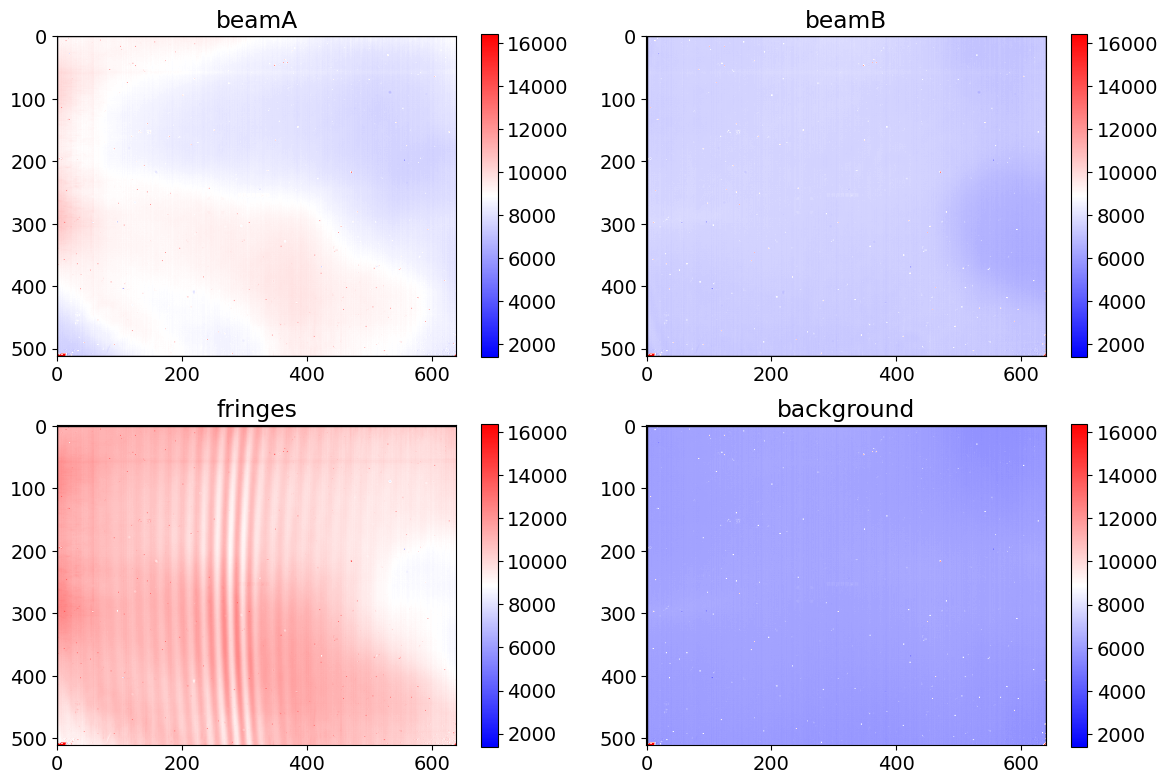

In [101]:
plt.figure(figsize= (12,8))

ax1= plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
rect1 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax1.add_patch(rect1)
plt.title("beamA")

ax2= plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
rect2 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax2.add_patch(rect2)
plt.title("beamB")

ax3= plt.subplot(2,2,3)
im=plt.imshow(reference, cmap='bwr')
plt.colorbar(im)
rect3 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax3.add_patch(rect3)
plt.title("fringes")

ax4= plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
rect4 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax4.add_patch(rect4)
plt.title("background")

plt.tight_layout()
plt.show()

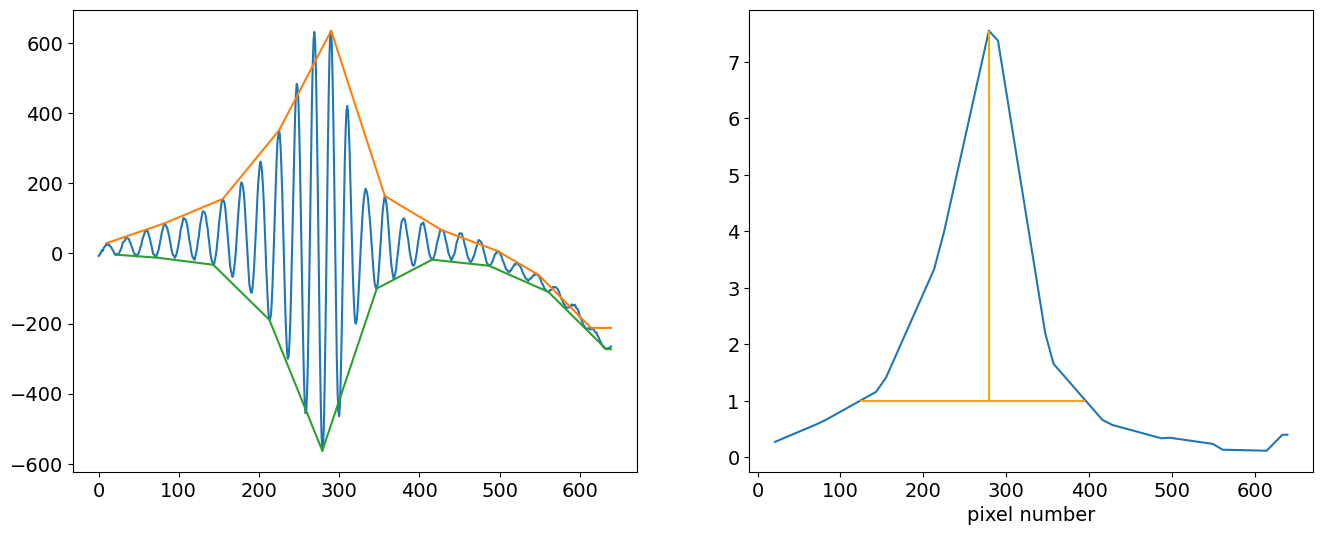

In [102]:
fringe_width_estimate = 50 #pixels. Small values may misidentify noise as fringes, large values may miss some fringes.

df = pd.DataFrame(reference_averaged, columns= ["interferogram"])
#df["rolling_average"] = df["interferogram"].rolling(5, center=True, min_periods= 0).mean() #Can be useful for reducing noise but also reduces contrast

peak_index, peak_properties = scisig.find_peaks(df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
df.loc[peak_index, "max"] = peak_properties["peak_heights"]
df["max"].interpolate(inplace=True)
peak_index, peak_properties = scisig.find_peaks(-df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
df.loc[peak_index, "min"] = -peak_properties["peak_heights"]
df["min"].interpolate(inplace=True)

df["range"] = df["max"] - df["min"]
noise = df["range"].min()

peak_index, peak_properties = find_best_peak(df["range"], height = 0, width = 0, rel_height= 0.9)
peak_left_index = peak_properties["left_ips"]
peak_right_index = peak_properties["right_ips"]
peak_height = peak_properties["peak_heights"]
peak_threshold = peak_properties["width_heights"]

high_contrast_region = [int(peak_left_index), int(peak_right_index)]

plt.figure(figsize= (16,6))

plt.subplot(1,2,1)
plt.plot(df["interferogram"])
plt.plot(df["max"])
plt.plot(df["min"])

plt.subplot(1,2,2)
plt.plot(df["range"] /peak_threshold)
plt.hlines(peak_threshold /peak_threshold, *high_contrast_region, color = "orange")
plt.vlines(peak_index, peak_threshold /peak_threshold, peak_height /peak_threshold, color= "orange")
plt.xlabel("pixel number")
plt.show()

reference_maximum = peak_index

Text(0.5, 1.0, 'processed fringes')

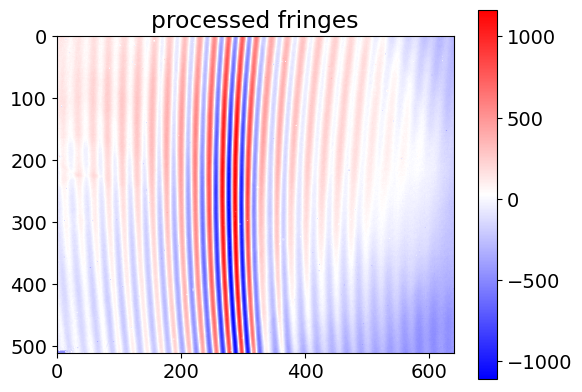

In [103]:
ax = plt.subplot(1,1,1)
im=plt.imshow(reference_processed, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

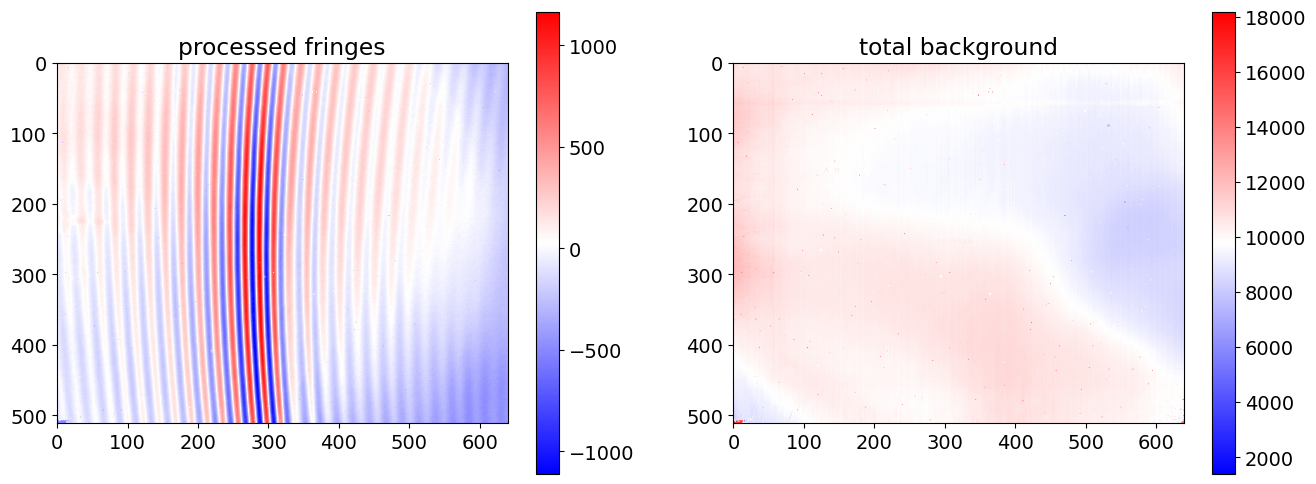

In [104]:
plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(reference_processed, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

plt.subplot(1,2,2)
im=plt.imshow(reference_nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

[0.00424874]


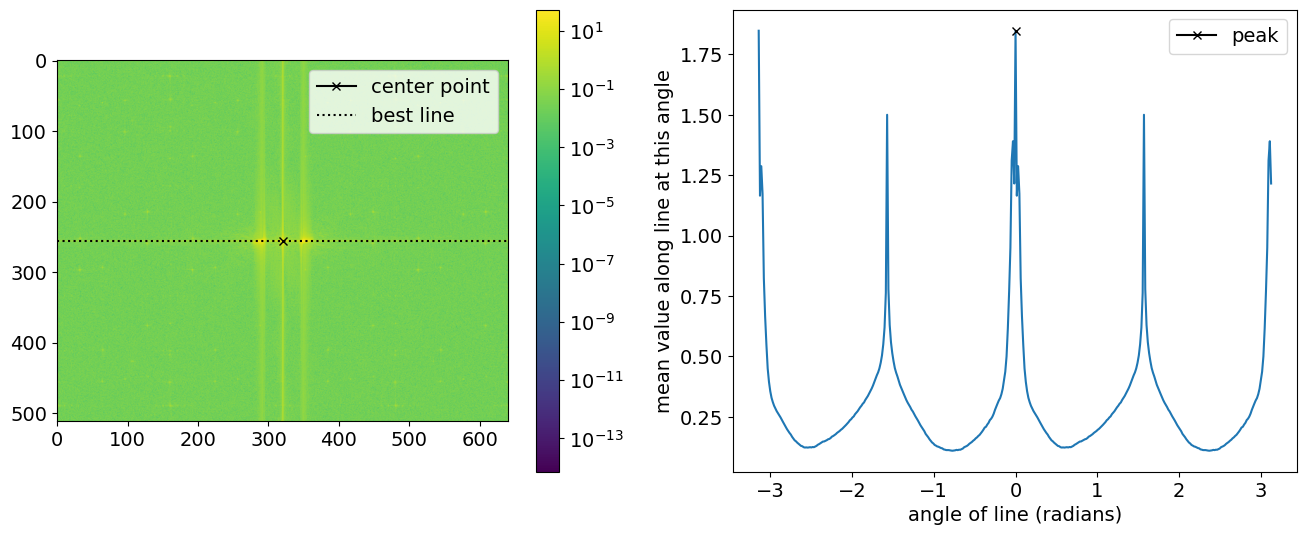

In [105]:
FT2d = np.fft.fftshift(np.fft.fft2(reference_processed, norm= "forward"))

minimisation_results = sciopt.minimize(angular_intergral, x0= 0, args= FT2d, bounds= [[-np.pi/4, np.pi/4]]) #Assume that the fringes are vertical to within 45 degrees. This avoids the strong line at 90 and -90 degrees. (Where does this line come from?)
min_phi, min_intergral = minimisation_results.x, minimisation_results.fun
print(min_phi*180/np.pi)

r = FT2d.shape[1]/2

x = np.arange(-r,r) *np.cos(min_phi) +np.diff(ROI[1])//2
y = np.arange(-r,r) *np.sin(min_phi) +np.diff(ROI[0])//2

plt.figure(figsize= (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(np.abs(FT2d), norm= "log")
ax.plot(np.diff(ROI[1])//2, np.diff(ROI[0])//2, marker= "x", color= "k", label= "center point")
ax.plot(x, y, color= "k", linestyle = ":", label= "best line")
plt.colorbar(im)
#plt.xlim(140, 180)
#plt.ylim(100, 140)
plt.legend()

ax1 = plt.subplot(1,2,2)
phis = np.arange(-np.pi, np.pi, np.pi/200)

intergral = []
for phi in phis:
    intergral = [*intergral, angular_intergral(phi, FT2d)]

plt.plot(phis, -np.array(intergral))
plt.plot(min_phi, -min_intergral, marker= "x", color= "k", label= "peak")
plt.xlabel("angle of line (radians)")
plt.ylabel("mean value along line at this angle")
plt.legend()


plt.show()

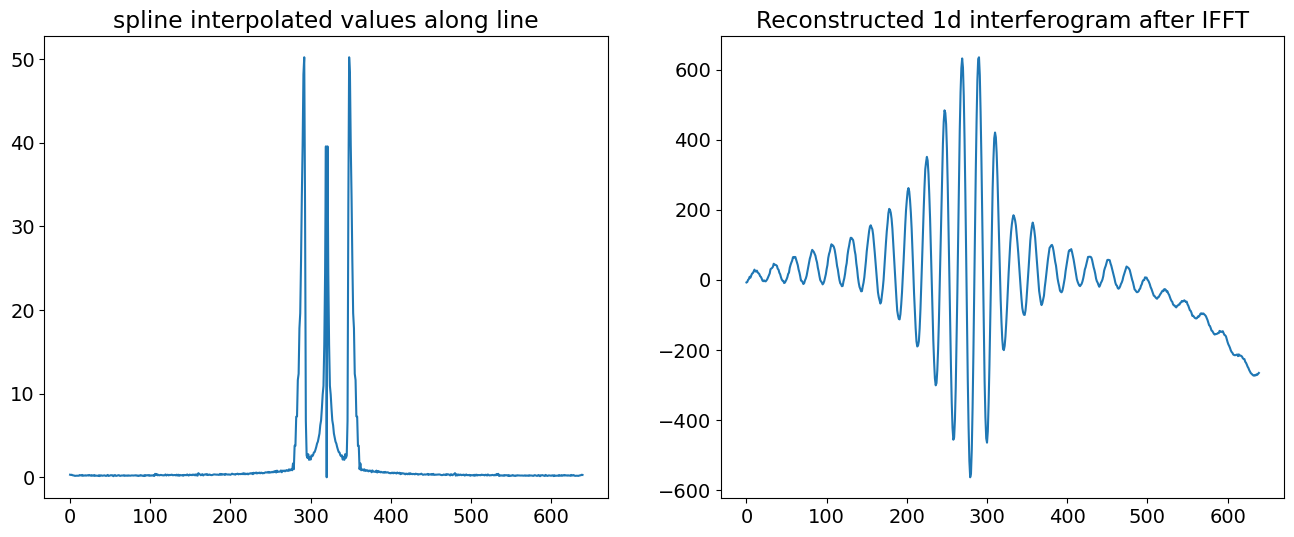

In [106]:
_, FT1d = angular_slice(min_phi, FT2d, width= 1)
reference_sliced = np.fft.ifft(np.fft.fftshift(FT1d), norm= "forward")


plt.figure(figsize= (16,6))

ax = plt.subplot(1,2,1)
ax.plot(np.abs(FT1d))
plt.title("spline interpolated values along line")

ax1 = plt.subplot(1,2,2)
ax1.plot(np.real(reference_sliced))
#ax1.plot(np.imag(reference_sliced))
plt.title("Reconstructed 1d interferogram after IFFT")

plt.show()

In [107]:
if anti_chirping == True:
    _, reference_unchirped = regularspacing(reference_sliced[high_contrast_region[0]:high_contrast_region[1]], reference_sliced)
else:
    reference_unchirped = reference_sliced

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


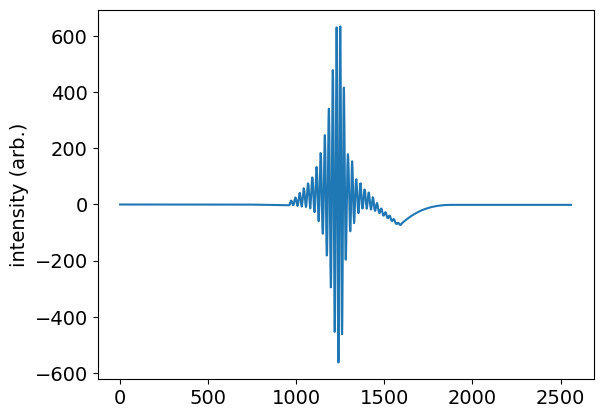

In [108]:
reference_zeropadded = zero_pad(reference_unchirped, zero_padding)
reference_apodized = apodization(reference_zeropadded, reference_maximum, function= apodization_function, L= len(reference_unchirped))

plt.plot(reference_apodized)
plt.ylabel("intensity (arb.)")
plt.show()

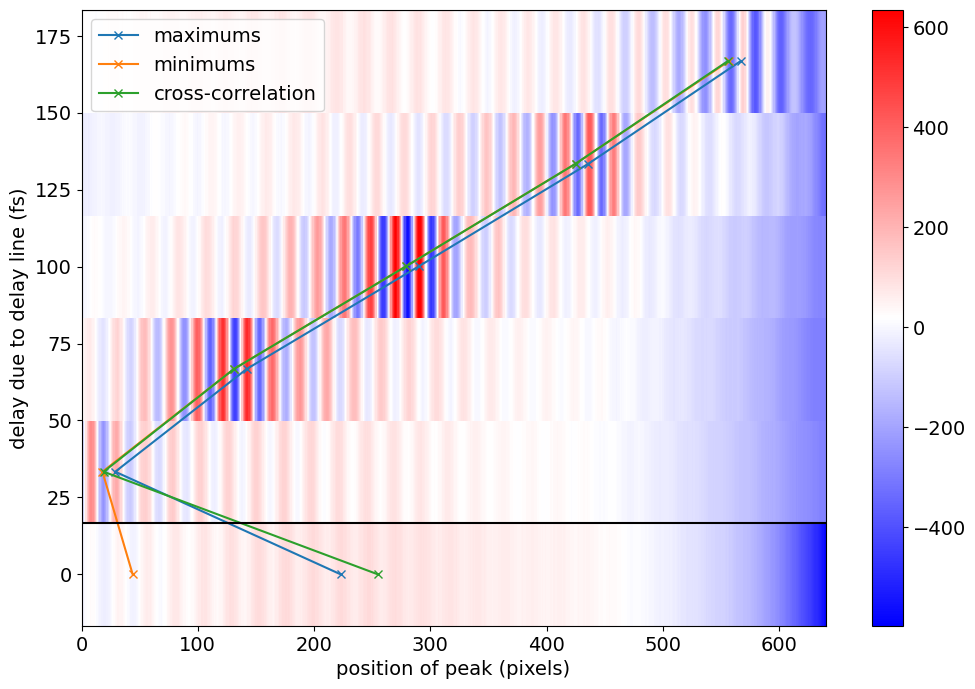

In [109]:
delay_line_bounds = [1,None] #As the fringes move outside of the high_contrast_region, the peak position becomes inaccurate. Use None to include the last interferogram

if angle_calculation_method == "delay":

    delay_line_travel = np.arange(fringes_averaged.shape[1]) *delay_line_delta
    time_delay = delay_line_travel *2 /c
    time_delay *= 1e9 #convert from us to fs

    #we found the maximums earlier
    minimums,_ = find_best_peak(-fringes_averaged)
    cross_corr_lags, cross_corr = apply_cross_corrlations(fringes_averaged, reference_apodized, reference_maximum= reference_maximum) #will fail if background is still present

    all_peak_estimates = maximums[delay_line_bounds[0]:delay_line_bounds[1]] #np.concatenate((maximums[delay_line_bounds[0]:delay_line_bounds[1]], minimums[delay_line_bounds[0]:delay_line_bounds[1]], cross_corr_lags[delay_line_bounds[0]:delay_line_bounds[1]]))
    time_delays = list(time_delay[delay_line_bounds[0]:delay_line_bounds[1]])*1 #3

    popt, pcov = sciopt.curve_fit(line, all_peak_estimates, time_delays)
    k = popt[0]
    m = popt[1]
    err_k = np.sqrt(pcov[0][0]) /k #make into percentage error
    err_m = np.sqrt(pcov[1][1]) /m

    plt.figure(figsize = (12,8))

    ax = plt.subplot(1,1,1)
    im=plt.imshow(np.transpose(fringes_averaged), 
                cmap='bwr', 
                aspect = "auto", 
                interpolation = "none", #"none" and "nearest" are the only physical ones
                origin = "lower", 
                extent=[0, fringes_averaged.shape[0], 0 -time_delay[1]/2, time_delay[-1] +time_delay[1]/2])
    plt.colorbar(im)
    plt.plot(maximums,
            time_delay,
            label = "maximums",
            marker = "x")
    plt.plot(minimums,
            time_delay,
            label = "minimums",
            marker = "x")
    plt.plot(cross_corr_lags,
            time_delay,
            label = "cross-correlation",
            marker = "x")
    # Datapoints between the black lines will be used to calculate the angle.
    plt.hlines([time_delay[delay_line_bounds[0]] -time_delay[1]/2, time_delay[none2zero(delay_line_bounds[1]) -1] +time_delay[1]/2], #y position(s)
               0, #x start
               fringes_averaged.shape[0], #x finish
               color = "k")
    plt.ylabel('delay due to delay line (fs)')
    plt.xlabel('position of peak (pixels)')
    plt.legend()

    plt.show()

In [110]:
fringes_averaged = fringes_averaged[:,1:]
delay_line_travel = delay_line_travel[1:]
maximums = maximums[1:]

In [139]:
path_difference = (delay_line_travel -delay_line_travel[2]) *2
path_delta = delay_line_delta *2

def displacement2time(displacement): #in um and fs
    return displacement /c *1e9
def time2displacement(time): #in um and fs
    return time *c *1e-9

time_delay = displacement2time(path_difference)
time_delta = displacement2time(path_delta)
#time_delay = time_delay[1:] - time_delay[1]

popt, pcov = sciopt.curve_fit(line, all_peak_estimates, time_delay)
k = popt[0]
m = popt[1]

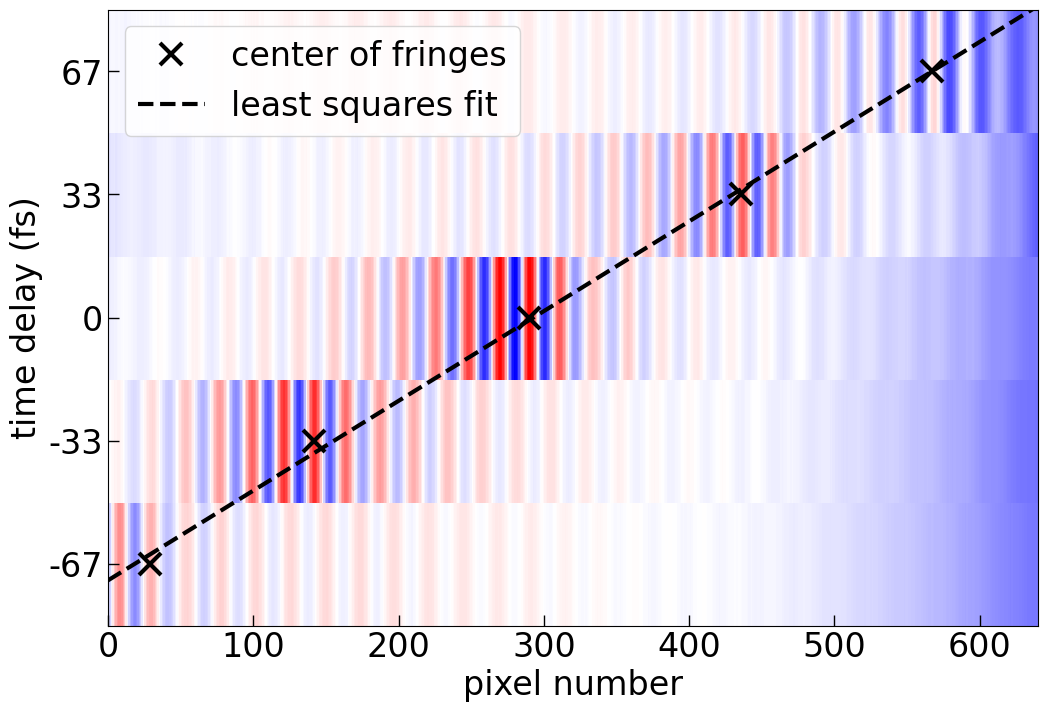

In [145]:
plt.rcParams.update({'font.size':24})
plt.figure(figsize = (12,8))

ax = plt.subplot(1,1,1)
im=plt.imshow(np.transpose(fringes_averaged), 
        cmap='bwr', 
        aspect = "auto", 
        interpolation = "none", #"none" and "nearest" are the only physical ones
        origin = "lower", 
        extent=[0, fringes_averaged.shape[0], time_delay[0] -time_delta/2, time_delay[-1] +time_delta/2])

plt.plot(maximums,
        time_delay,
        label = "center of fringes",
        marker = "x",
        markersize = 16,
        color= "k",
        linestyle= "None",
        markeredgewidth= 3)

x = np.arange(fringes_averaged.shape[0])
plt.plot(x,
        line(x,k,m),# - time_delay[1],
        label = "least squares fit",
        color= "k",
        linestyle= "--",
        linewidth= 3)

plt.ylabel('time delay (fs)')
plt.xlabel('pixel number')

plt.yticks(time_delay)
ax.tick_params(direction= "in", length= 8, width= 1)
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.ylim(time_delay[0] -time_delta/2, time_delay[-1] +time_delta/2) # the best fit line may overflow outside of the interferograms
plt.xlim(0, fringes_averaged.shape[0])

#secax = ax.secondary_yaxis("right", functions= (time2displacement, displacement2time))
#secax.set_ylabel('path difference ($\mu$m)')
#secax.set_yticks(path_difference)
#secax.yaxis.set_major_formatter(FuncFormatter(format_ticks))


plt.legend()

plt.show()

In [112]:
if angle_calculation_method == "delay":
    print("gradient = {0:.2e} +/- {1:.1e} ".format(m, err_m*m) + "fs/pixel")

    m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to us/um (= s/m)
    theta = np.arcsin(c *np.abs(m) /2 ) 
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    err_angle = angle_between_beams *np.abs(err_m) #relies on the small angle appoximation.
    print("angle between beams = {0:.3f} +/- {1:.3f}° or {2:.1f} +/- {3:.1f} arcminutes".format(angle_between_beams, 2*err_angle, 60*angle_between_beams, 60*2*err_angle))

gradient = 2.43e-01 +/- 6.0e-03 fs/pixel
angle between beams = 0.209 +/- 0.010° or 12.5 +/- 0.6 arcminutes


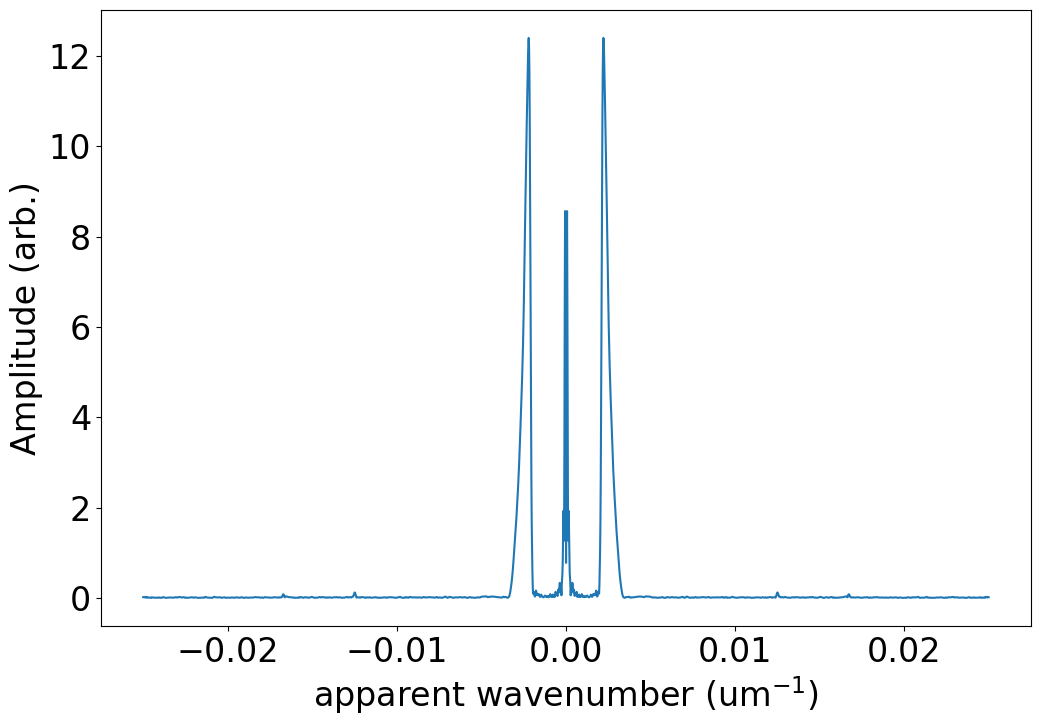

In [113]:
FT = np.fft.fft(reference_apodized, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.fft.fftfreq(len(FT), pixel_pitch)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(np.fft.fftshift(freqs), #plt works best when the data set is in order
        np.fft.fftshift(abs(FT)))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_744\1790296155.py:307: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs


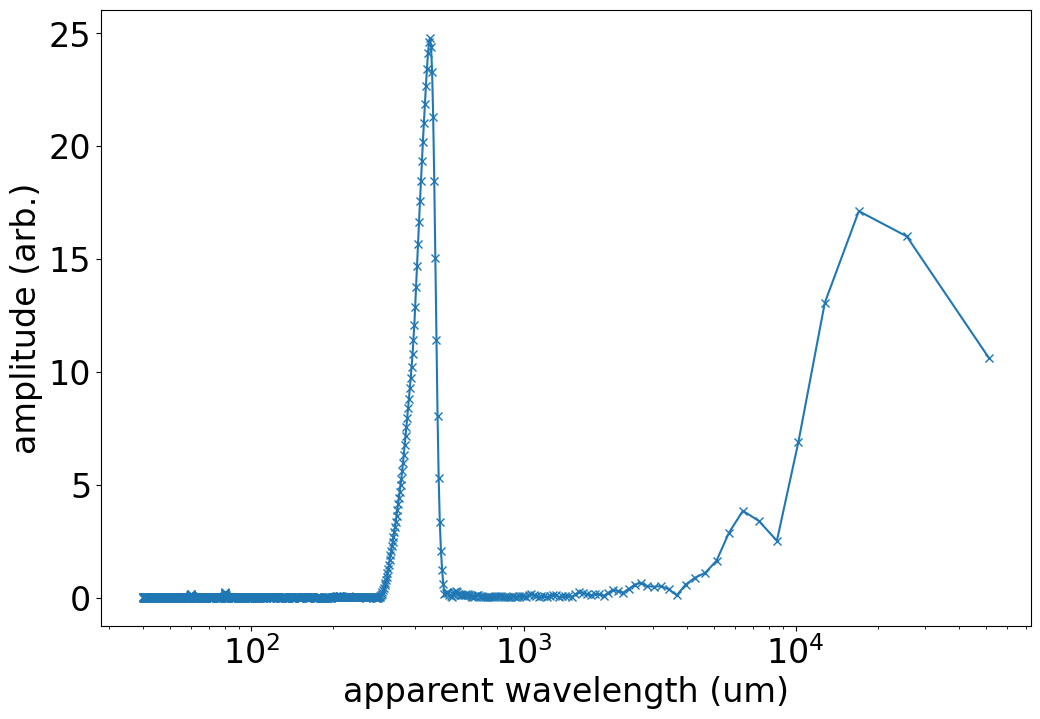

In [114]:
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])
amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths,
        amplitude,
        marker = "x")
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

In [115]:
################COMPENSATE FOR ANGLE#################
if angle_calculation_method == "manual":
    theta = angle_between_beams/2 *np.pi/180
if angle_calculation_method == "wavelength":

    peaks, peak_properties = scisig.find_peaks(amplitude[1:], prominence = 0)
    best_peak = np.argmax(peak_properties["prominences"])
    max_index = peaks[best_peak] +1

    theta = np.arcsin(calibration_wavelength /2 /wavelengths[max_index])
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    print("angle between beams = {0:.3f}° or {1:.1f} arcminutes".format(angle_between_beams, 60*angle_between_beams))

corrected_wavelengths = wavelengths *2*np.sin(theta)
corrected_frequencys = recip(corrected_wavelengths)

In [116]:
###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise

manta_data = import_normalised_csv("mantra_spectrum.csv", 0)
manta_data[:,0] = recip(manta_data[:,0]*1e-3) #convert nm to THz
manta_function = sciinter.interp1d(manta_data[:,0], manta_data[:,1], fill_value= np.nan, bounds_error= False)

purple_data = import_normalised_csv("PV320_spectrum.csv", 0)
purple_data[:,0] = recip(purple_data[:,0]*1e-3) #convert nm to THz
purple_function = sciinter.interp1d(purple_data[:,0], purple_data[:,1], fill_value= np.nan, bounds_error= False)

ir_data = import_normalised_csv("SLS201L_spectrum.csv", 1)
ir_data[:,0] = recip(ir_data[:,0]*1e-3) #convert nm to THz
ir_function = sciinter.interp1d(ir_data[:,0], ir_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

big_data = import_normalised_csv("SLS303_spectrum.csv", 1)
big_data[:,0] = recip(big_data[:,0]*1e-3) #convert nm to THz
big_function = sciinter.interp1d(big_data[:,0], big_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

def camera_function(x):
        return (manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))


def manufacturers_function(x):
        return (ir_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                big_function(x)**(source == "big") *
                manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))

percentagediff = (manufacturers_function(corrected_frequencys[:-1]) - amplitude[:-1]) /amplitude[:-1]
amplitude *= np.nanpercentile(percentagediff[percentagediff != -1], 10) +1 #re-scale to fit

normalised_amplitude = amplitude / camera_function(corrected_frequencys) #factor in the camera sensitivity

C:\Users\syf83691\AppData\Local\Temp\ipykernel_744\1790296155.py:16: RuntimeWarning: divide by zero encountered in divide
  return c*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa.


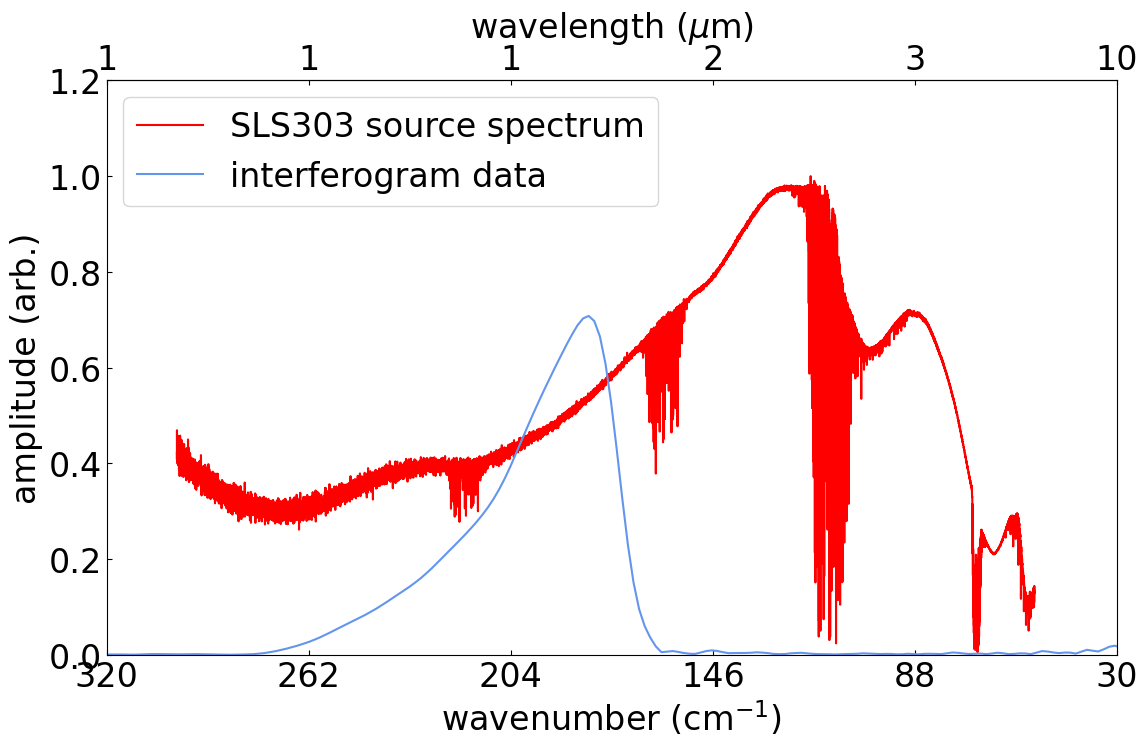

In [117]:
frequency_limits = [30,320] #THz

###Create graph
plt.figure(figsize = (12,8))
ax1 = plt.subplot(1, 1, 1)

###Import data to plot
if camera == "manta": 
        ax1.plot(manta_data[:,0],
                manta_data[:,1],
                label = "Manta camera spectral response",
                color = "orange",
                linestyle = "--")
        ax1.plot(corrected_frequencys,
                normalised_amplitude,
                label = "normalised interferogram data",
                color = "blue")
elif camera == "purple":
        ax1.plot(purple_data[:,0],
                purple_data[:,1],
                label = "PV320 camera spectral response",
                color = "violet",
                linestyle = "--")
        ax1.plot(corrected_frequencys,
                normalised_amplitude,
                label = "normalised interferogram data",
                color = "blue")
if angle_calculation_method == "wavelength":
        try:
                plt.axvline(recip(calibration_wavelength), color = source)
        except ValueError:
                plt.axvline(recip(calibration_wavelength), color = "k")
if source == "ir":
        ax1.plot(ir_data[:,0],
                ir_data[:,1],
                label = "SLS201L source spectrum",
                color = "red")
elif source == "big":
        ax1.plot(big_data[:,0],
                big_data[:,1],
                label = "SLS303 source spectrum",
                color = "red")

ax1.plot(corrected_frequencys,
        amplitude,
        label = "interferogram data",
        color = "cornflowerblue")

###customise axis
secax = ax1.secondary_xaxis('top', functions=(recip, recip))

ax1.set_xlabel('wavenumber (cm$^{-1}$)')
ax1.set_xticks(np.linspace(*frequency_limits,6))
ax1.tick_params(direction = "in")
secax.set_xlabel('wavelength ($\mu$m)')
secax.set_xticks(recip(np.linspace(*frequency_limits,6)))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
secax.tick_params(direction = "in")

plt.ylabel('amplitude (arb.)')
plt.ylim(0,1.2)
plt.xlim(*frequency_limits[::-1])

###show legend and graph
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
#to_plot_purple = reference_processed[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]]
#to_plot_purple_freqs = corrected_frequencys
#to_plot_purple_amps = normalised_amplitude
#to_plot_purple_1d = reference_sliced
#to_plot_xeva = reference_processed[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]]
#to_plot_xeva_freqs = corrected_frequencys
#to_plot_xeva_amps = normalised_amplitude
#to_plot_xeva_1d = reference_sliced

NameError: name 'to_plot_xeva' is not defined

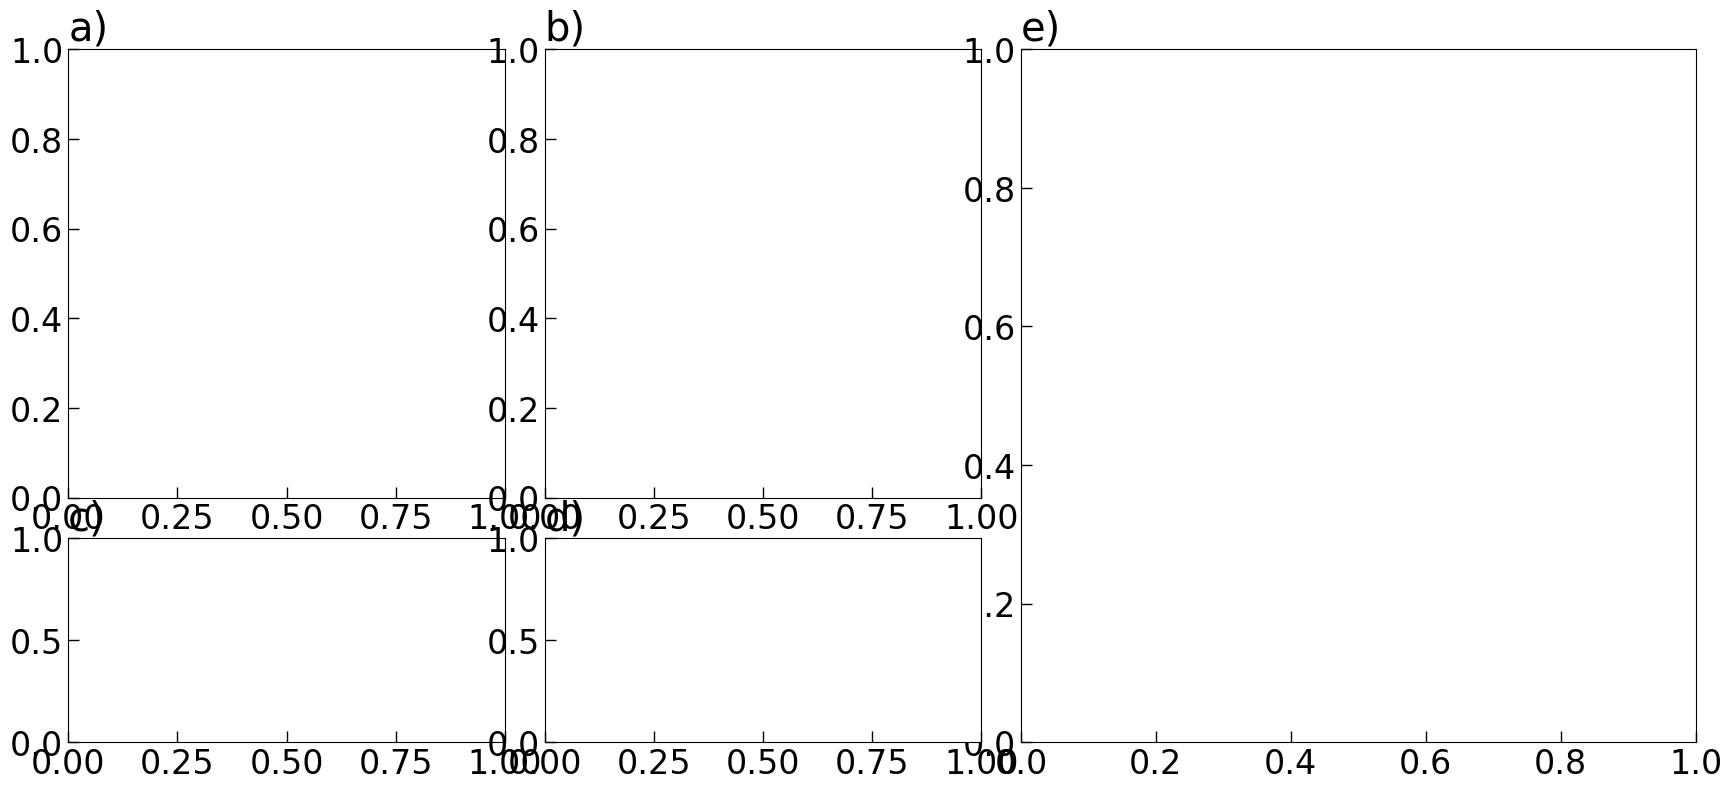

In [119]:
axs_mosaic = [["a)", "a)", "b)", "b)", "e)", "e)", "e)"],
              ["a)", "a)", "b)", "b)", "e)", "e)", "e)"],
              ["c)", "c)", "d)", "d)", "e)", "e)", "e)"]]
fig, axs = plt.subplot_mosaic(axs_mosaic, figsize= (21,9))

[ax.tick_params(direction= "in", length= 8, width= 1) for ax in axs.values()] #dictionary comprehention! Applies the function to every axis apart from secax.
[ax.set_title(label, loc='left') for label, ax in axs.items()] #Each `item` in a dictionary has a pair of `keys` and `values`. dict= {item1, item2, item3}. item1 = key1: value1

axs["a)"].imshow(to_plot_xeva, cmap='bwr')
axs["a)"].set(xlabel= "pixel number", ylabel= "pixel number") #, title= "Processed fringes on XEVA-FPA 640")

axs["c)"].plot(to_plot_xeva_1d)
axs["c)"].sharex(axs["a)"])
axs["c)"].tick_params(bottom= False, labelbottom= False, top= True, labeltop= True)
axs["c)"].set_ylabel("intensity (counts)", labelpad= 0)

axs["b)"].imshow(to_plot_purple, cmap='bwr')
axs["b)"].set(xlabel= "pixel number", ylabel= "pixel number") #, title= "Processed fringes on PV320")

axs["d)"].plot(to_plot_purple_1d)
axs["d)"].sharex(axs["b)"])
axs["d)"].tick_params(bottom= False, labelbottom= False, top= True, labeltop= True)
axs["d)"].set_ylabel("intensity (counts)", labelpad= -10)

axs["e)"].plot(big_data[:,0],
                big_data[:,1],
                label = "SLS303 source spectrum",
                color = "red")
axs["e)"].plot(to_plot_xeva_freqs,
                to_plot_xeva_amps *0.7,
                label = "XEVA-FPA 640 data",
                color = "dodgerblue",
                linestyle = "-.")
axs["e)"].plot(to_plot_purple_freqs,
                to_plot_purple_amps,
                label = "PV320 data",
                color = "mediumorchid",
                linestyle = "-.")

###customise axis
secax = axs["e)"].secondary_xaxis('top', functions=(recip, recip))

axs["e)"].set_xlabel('frequency (THz)')
axs["e)"].set_xticks([40,80,120,160,200,240,280,320])
secax.set_xlabel('wavelength ($\mu$m)')
secax.set_xticks(recip(np.array([40,80,120,160,200,240,280,320])))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
secax.tick_params(direction= "in", length= 8, width= 1) #secax in not a part of the axs dictionary so it didn't get the memo.

axs["e)"].set(ylabel= 'amplitude (arb.)', ylim= (0,1.2), xlim= frequency_limits[::-1])
axs["e)"].legend(loc= "upper left")

plt.tight_layout(pad= 0.5)
plt.show()